In [471]:
import csv
import numpy as np

# Function to read transportation problem data from a CSV file
def read_transportation_problem(file_path):
    print("Reading transportation problem data from:", file_path)
    
    # Initialize empty lists for supply, demand, and costs
    supply, demand, costs = [], [], []

    try:
        # Open the CSV file
        with open(file_path, 'r') as file:
            # Create a CSV reader object, specifying the delimiter and quoting option
            reader = csv.reader(file, delimiter=';', quoting=csv.QUOTE_NONNUMERIC)

            # Iterate over each row in the CSV file
            for i, row in enumerate(reader):
                # If it's the first row (index 0), it contains supply values
                if i == 0:
                    supply = np.array(row)  # Convert the row to a numpy array and store it as supply
                # If it's the second row (index 1), it contains demand values
                elif i == 1:
                    demand = np.array(row)  # Convert the row to a numpy array and store it as demand
                # For all other rows, they contain transportation costs
                else:
                    costs.append(row)  # Append the row to the costs list
                    
        # Convert the lists to numpy arrays
        supply = np.array(supply)
        demand = np.array(demand)
        costs = np.array(costs)
        
        # Print summary information
        print("Supply:", supply)
        print("Demand:", demand)
        print("Costs:")
        print(costs)
        
        print("Transportation problem data read successfully.")
        
        # Return the supply, demand, and costs arrays
        return supply, demand, costs
    
    except Exception as e:
        print("Error reading transportation problem data:", e)
        return None, None, None

# Example usage:
file_path = "LPproblem.txt"
supply, demand, costs = read_transportation_problem(file_path)


Reading transportation problem data from: D:/Donwloads/LPproblem.txt
Supply: [35. 50. 40.]
Demand: [45. 20. 30. 30.]
Costs:
[[ 8.  6. 10.  9.]
 [ 9. 12. 13.  7.]
 [14.  9. 16.  5.]]
Transportation problem data read successfully.


In [472]:
# Function to apply the Northwest Corner Rule to initialize a transportation solution
def nw_corner_rule(supply, demand):
    # Initialize an empty solution matrix with zeros
    solution = np.zeros((len(supply), len(demand)))
    x, y = 0, 0  # Initialize indices for the Northwest corner of the solution matrix
    
    # Iterate until either supply or demand is exhausted
    while y < len(supply) and x < len(demand):
        # Assign the minimum between supply[y] and demand[x] to the current cell in the solution matrix
        solution[y, x] = min(supply[y], demand[x])
        
        # Reduce the supply and demand accordingly
        demand[x] -= solution[y, x]
        supply[y] -= solution[y, x]
        
        # Move to the next column if demand for the current column is satisfied
        if demand[x] == 0:
            x += 1
        # Move to the next row if supply for the current row is satisfied
        if supply[y] == 0:
            y += 1
    
    # Return the initialized solution matrix
    return solution


In [473]:
def get_w(solution, costs):
    # Get the number of rows and columns in the solution matrix
    nrows, ncols = len(solution), len(solution[0])
    
    # Initialize potentials u and v
    u = [None] * nrows
    u[0] = 0
    v = [None] * ncols

    # Find indices of non-zero elements in the solution matrix
    nonzero = [(i, j) for i in range(nrows) for j in range(ncols) if solution[i][j] > 0]

    # Calculate potentials u and v until all elements are filled
    while any(x is None for x in u) or any(y is None for y in v):
        for i, j in nonzero:
            if u[i] is None and v[j] is not None:
                u[i] = costs[i][j] - v[j]
            elif u[i] is not None and v[j] is None:
                v[j] = costs[i][j] - u[i]

    # Calculate the opportunity cost matrix w
    w = [[-float('inf') if solution[y][x] != 0 else u[y] + v[x] - costs[y][x] for x in range(ncols)] for y in range(nrows)]

    # Find the maximum cell in w based on the opportunity costs and cycles in the solution
    i_max = (0, 0)
    for i in range(nrows):
        for j in range(ncols):
            if w[i][j] > w[i_max[0]][i_max[1]] and get_cycle(solution, (i, j)) != []:
                i_max = (i, j)
    
    return w, i_max


In [474]:
def get_cycle(solution, start_index):
    # Get the number of rows and columns in the solution matrix
    n, m = len(solution), len(solution[0])
    paths = []

    # Function to check if a given index is valid
    def is_valid_index(i, j):
        return 0 <= i < n and 0 <= j < m

    # Recursive function to search for cycles starting from a given index
    def search(i, j, path, solution):
        # If the path has four points, it forms a cycle and is added to the paths list
        if len(path) == 4:
            paths.append(path.copy())
            return

        # Explore all possible adjacent cells
        for x in range(n):
            for y in range(m):
                # Check if the index is valid and not already in the path
                if is_valid_index(x, y) and (x, y) not in path:
                    # Recursively search for cycles
                    search(x, y, path + [(x, y)], solution)

    # Start the search from the specified start index
    i, j = start_index
    search(i, j, [(i, j)], solution)

    # Filter out invalid paths
    paths = [p for p in paths if all(solution[y][x] > 0 for y, x in p[1:])]
    paths = [p for p in paths if len(set(y for y, _ in p)) == 2 and len(set(x for _, x in p)) == 2]
    paths = [p for p in paths if not any(p[i-1][0] != p[i][0] and p[i-1][1] != p[i][1] for i in range(len(p)))]

    # If no valid paths are found, return an empty list
    if not paths:
        return []

    # Return the first valid path found
    return paths[0]


In [475]:
def get_total_cost(solution, costs):
    # Element-wise multiplication of the solution matrix with the costs matrix
    total_cost = np.sum(solution * costs)
    
    return total_cost


In [484]:
def transportation(supply, demand, costs):
    # Ensure the problem is balanced
    assert sum(supply) == sum(demand), "Supply and demand should be balanced."

    # Initialize solution using the Northwest Corner Rule
    solution = nw_corner_rule(supply, demand)
    
    # Initialize list to store the evolution of total costs
    costs_evolution = [get_total_cost(solution, costs)]
    
    # Set maximum number of iterations
    max_iter = 25
    
    # Iteratively optimize the solution
    while max_iter > 0:
        # Calculate opportunity cost matrix and entering cell
        w, i_max = get_w(solution, costs)
        
        # If no improvement can be made, break out of the loop
        if all(cell <= 0 for row in w for cell in row):
            break
        
        # Find a cycle and determine the theta value
        cycle = get_cycle(solution, i_max)
        theta = min(solution[cycle[-1]], solution[cycle[1]])
        
        # Update the solution with the cycle
        for i, cell in enumerate(cycle):
            solution[cell] += theta if i % 2 == 0 else -theta
                
        # Record the total cost of the updated solution
        costs_evolution.append(get_total_cost(solution, costs))
        
        # Decrement the maximum number of iterations
        max_iter -= 1
    
    # Return the final solution, total cost, and cost evolution
    return solution, get_total_cost(solution, costs), costs_evolution


In [485]:
# Define the file path
file_path = "D:/Donwloads/LPproblem.txt"

# Read transportation problem data from the CSV file
supply, demand, costs = read_transportation_problem(file_path)
# Solve the transportation problem
solution, total_cost, costs_evolution = transportation(supply, demand, costs)

# Output the results
print("Transportation Matrix:")
print(solution)
print("\nTotal Cost:", total_cost)
print("\nCost Evolution Over Iterations:")
print(costs_evolution)

Reading transportation problem data from: D:/Donwloads/LPproblem.txt
Supply: [35. 50. 40.]
Demand: [45. 20. 30. 30.]
Costs:
[[ 8.  6. 10.  9.]
 [ 9. 12. 13.  7.]
 [14.  9. 16.  5.]]
Transportation problem data read successfully.
Transportation Matrix:
[[ 0. 10. 25.  0.]
 [45.  0.  5.  0.]
 [ 0. 10.  0. 30.]]

Total Cost: 1020.0

Cost Evolution Over Iterations:
[1180.0, 1120.0, 1070.0, 1020.0]


In [486]:
# Define the file path
file_path = "LPproblem2.txt"

# Read transportation problem data from the CSV file
supply, demand, costs = read_transportation_problem(file_path)
# Solve the transportation problem
solution, total_cost, costs_evolution = transportation(supply, demand, costs)

# Output the results
print("Transportation Matrix:")
print(solution)
print("\nTotal Cost:", total_cost)
print("\nCost Evolution Over Iterations:")
print(costs_evolution)

Reading transportation problem data from: D:/Donwloads/LPproblem2.txt
Supply: [20. 20. 25.]
Demand: [12. 14. 12. 18.  9.]
Costs:
[[28.  7. 16.  2. 30.]
 [18.  8. 14.  4. 20.]
 [10. 12. 13.  5. 28.]]
Transportation problem data read successfully.
Transportation Matrix:
[[ 0.  3.  0. 17.  0.]
 [ 0. 11.  0.  0.  9.]
 [12.  0. 12.  1.  0.]]

Total Cost: 604.0

Cost Evolution Over Iterations:
[948.0, 882.0, 858.0, 774.0, 646.0, 637.0, 615.0, 604.0]


Reading transportation problem data from: D:/Donwloads/LPproblem.txt
Supply: [35. 50. 40.]
Demand: [45. 20. 30. 30.]
Costs:
[[ 8.  6. 10.  9.]
 [ 9. 12. 13.  7.]
 [14.  9. 16.  5.]]
Transportation problem data read successfully.


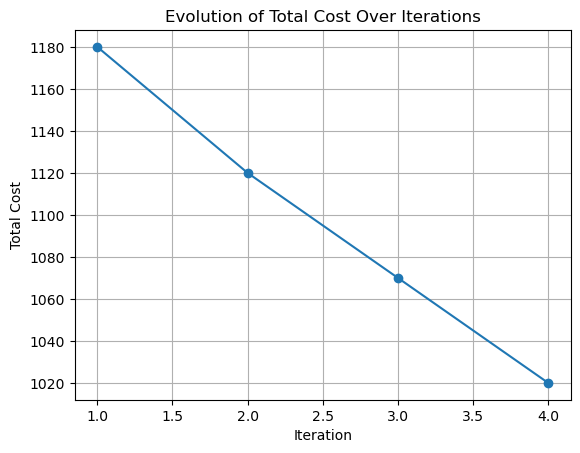

In [487]:
import csv
import numpy as np
import matplotlib.pyplot as plt  # Import Matplotlib for plotting

# Function definitions...

# Main code...
file_path = "LPproblem.txt"
supply, demand, costs = read_transportation_problem(file_path)
solution, total_cost, costs_evolution = transportation(supply, demand, costs)

# Plot the evolution of costs over iterations starting from 1
iterations = range(1, len(costs_evolution) + 1)
plt.plot(iterations, costs_evolution, marker='o')
plt.title('Evolution of Total Cost Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Total Cost')
plt.grid(True)
plt.show()


Reading transportation problem data from: D:/Donwloads/LPproblem2.txt
Supply: [20. 20. 25.]
Demand: [12. 14. 12. 18.  9.]
Costs:
[[28.  7. 16.  2. 30.]
 [18.  8. 14.  4. 20.]
 [10. 12. 13.  5. 28.]]
Transportation problem data read successfully.


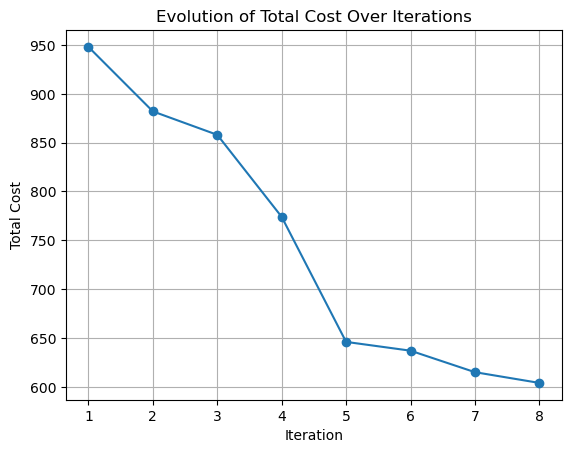

In [488]:
import csv
import numpy as np
import matplotlib.pyplot as plt  # Import Matplotlib for plotting

# Function definitions...

# Main code...
file_path = "LPproblem2.txt"
supply, demand, costs = read_transportation_problem(file_path)
solution, total_cost, costs_evolution = transportation(supply, demand, costs)

# Plot the evolution of costs over iterations starting from 1
iterations = range(1, len(costs_evolution) + 1)
plt.plot(iterations, costs_evolution, marker='o')
plt.title('Evolution of Total Cost Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Total Cost')
plt.grid(True)
plt.show()
